# B52 Künstliche Intelligenz und Big Data Analytics - Semesterprojekt SoSe 2024
## Name: Andersson, Billy Kid
## Matrikelnr: s0585550


In [2]:
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.wrappers import FrameStack
from gymnasium.wrappers import PixelObservationWrapper
from gymnasium.wrappers import StepAPICompatibility
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os
from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage
import matplotlib.pyplot as plt
import cv2
import numpy as np
import gc
import torch.optim as optim
import torch.nn.functional as F
import retro
import matplotlib.pyplot as plt
import matplotlib.image as mpimg





class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """
        Frames werden geskippt
        """
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """
        Wiederholte aktion für geskippte Frames durchführen und belohnung summieren
        """
        total_reward = 0.0
        for i in range(self._skip):
            
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=240, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=240, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 240)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Stacked Frames Temporal understanding

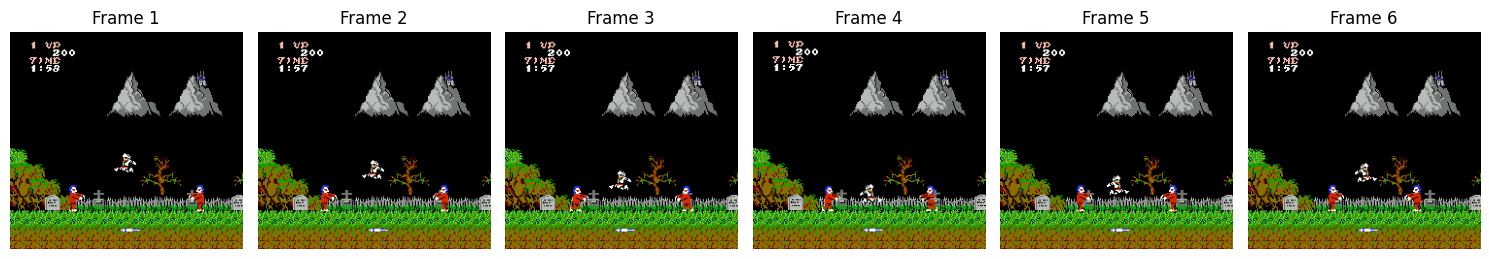

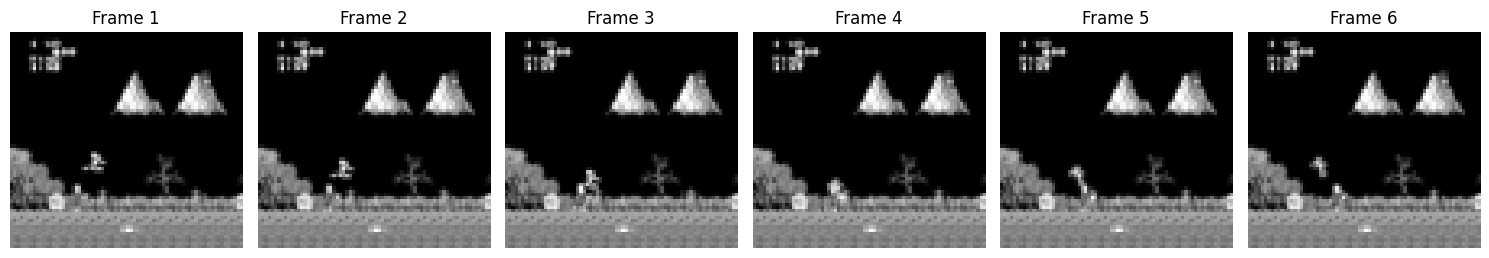

In [15]:
env = retro.make(game='GhostsnGoblins-Nes', render_mode='rgb-array')
env = SkipFrame(env, skip=6) 

if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=6, new_step_api=True)
else:
    env = FrameStack(env, num_stack=6)
env.reset()
for x in range(20):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    plt.show(observation)
    
    
env.close()
num_frames = observation.shape[0]


fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))


for i in range(num_frames):
    ax = axes[i]
    ax.imshow(observation[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Frame {i+1}')

plt.tight_layout()
plt.show()



env = retro.make(game='GhostsnGoblins-Nes', render_mode='rgb-array')
env = SkipFrame(env, skip=6) 
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=(67,72))
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=6, new_step_api=True)
else:
    env = FrameStack(env, num_stack=6)
env.reset()
for x in range(20):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    plt.show(observation)
    
    
env.close()

num_frames = observation.shape[0]


fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))


for i in range(num_frames):
    ax = axes[i]
    ax.imshow(observation[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Frame {i+1}')

plt.tight_layout()
plt.show()


In [20]:
env.close()
stacked_frames = 6
env = retro.make(game='GhostsnGoblins-Nes', render_mode='rgb-array')
env = SkipFrame(env, skip=stacked_frames) 
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=(67,72))

if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=stacked_frames, new_step_api=True)
else:
    env = FrameStack(env, num_stack=stacked_frames)
env.reset()

(<gymnasium.wrappers.frame_stack.LazyFrames at 0x7f196457c0e0>, {})

In [21]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        c, h, w = input_dim
        self.conv1 = nn.Conv2d(c, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self._calculate_conv_output_size((c, h, w)), 512)
        self.fc2 = nn.Linear(512, output_dim)

    def _calculate_conv_output_size(self, shape):
        c, h, w = shape
        x = torch.randn(1, c, h, w)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(np.prod(x.size()))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [71]:
from collections import deque
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class DQNAgent:
    def __init__(self, env, input_dim, output_dim, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.999995, lr=0.001, replay_memory_size=10000, batch_size=32):

        self.env = env
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.lr = lr
        self.batch_size = batch_size
        self.device =torch.device("cpu")

        
        self.replay_memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(replay_memory_size, device=torch.device("cpu")))

        self.model = DQN(input_dim, output_dim)
        self.target_model = DQN(input_dim, output_dim)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def choose_action(self, state):

        if isinstance(state, (int, float)): 
            state = torch.FloatTensor([state]).unsqueeze(0) 
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)  
    
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()  
        else:
            q_values = self.model(state)
            #print(q_values)
            probs = F.softmax(q_values, dim=-1) #
            #print(probs)
            threshold = 0.11 
            #print(probs)
            q_values = (probs > threshold).int() #entscheidung welche Erfahrungen wertvoll sind
            action_index = q_values.argmax().item()
            #action_index = torch.argmax(q_values, axis=1).item
            #action_index = action_index[0].item()
            #print(action_index)
            #print(q_values[action_index])
            return q_values[action_index]


    def remember(self, state, action, reward, next_state, done):
        """
        Speichern von Erfahrungen im Replay Buffer
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(np.array(state))
        self.replay_memory.add(TensorDict({
                "state": state,
                "action": torch.tensor(np.array([action]), dtype=torch.int64, device=self.device),  
                "reward": torch.tensor(np.array([reward]), dtype=torch.float32, device=self.device),
                "next_state": next_state,
                "done": torch.tensor(np.array([done]), dtype=torch.float32, device=self.device)
        }, batch_size=[]))

    def replay(self):
        """
        Agent nimmt States aus dem replay memory um Korrelation zwischen 
        states zu reduzieren damit der Agent neue Erfahrungen besser verwerten kann.

        verbessert effizienz beim Training
        """
     
        if len(self.replay_memory) < self.batch_size:
            return
        
        batch = self.replay_memory.sample(self.batch_size)#.to(self.device)
        states = batch['state']
        actions = batch['action'].squeeze().argmax(dim=1)
        rewards = batch['reward'].squeeze()
        next_states = batch['next_state']
        dones = batch['done'].squeeze().float()

        #current_q_values = self.model(states) #old code rev 1.0
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()
        
        next_q_values = self.target_model(next_states).max(1)[0].detach()
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

       
        #target_q_values = target_q_values.unsqueeze(1) # old code rev 1.0
        #current_q_values = current_q_values.unsqueeze(1) # old code rev 1.0

        target_q_values = target_q_values.view(-1) 
        #current_q_values = current_q_values.view(-1)
        
        loss = self.loss_fn(current_q_values, target_q_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def train(self, episodes=10000, max_steps_per_episode=1000000):
        scores = []
        rewards_list =[]
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            score = 0
            time = 0
            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                next_state, reward, done, truncated, info = self.env.step(action)
                if info["score"] % 200 == 0 and score != info["score"]:
                    reward += 0.1
                    score = info["score"]
                total_seconds = info["time_minutes"] * 60 + info["time_tens"] * 10 + info["time_ones"]
                if time > total_seconds:
                    reward += 0.025
                    time = total_seconds

                self.remember(state, action, reward, next_state, done)
                state = next_state

                self.replay()

                total_reward += reward
                if done:
                    break

            rewards_list.append(total_reward)
            if (episode + 1) % 500 == 0: #10 before
                self.update_target_model()
            if (episode + 1) % 5 == 0:
                mean_reward = (sum(rewards_list)/5)
                rewards_list = []
                scores.append(mean_reward)
                print(f"Episode {episode + 1}/{episodes}, Score: {mean_reward}, Epsilon: {self.epsilon:.2f}")
                plt.plot(scores)
                plt.xlabel('Episodes')
                plt.ylabel('Total Reward')
                plt.title('Training Rewards')
                plt.grid(True)
                plt.savefig('training_rewards.png')
                plt.show()
                

        torch.save(self.model.state_dict(), 'trained_model.pth')

        print('Training complete.')
        
        return scores



Episode 5/10000, Score: 0.8399999999999999, Epsilon: 0.99


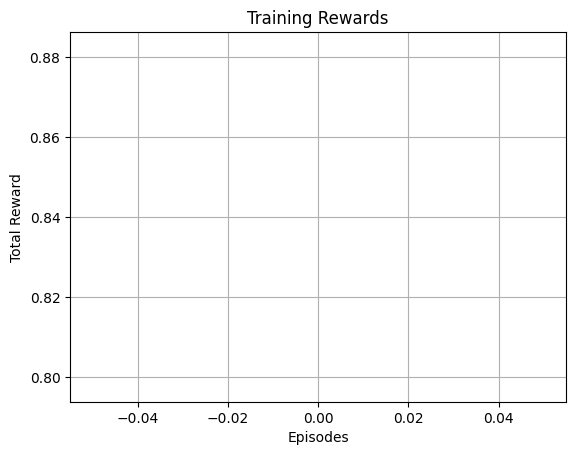

Episode 10/10000, Score: 0.78, Epsilon: 0.97


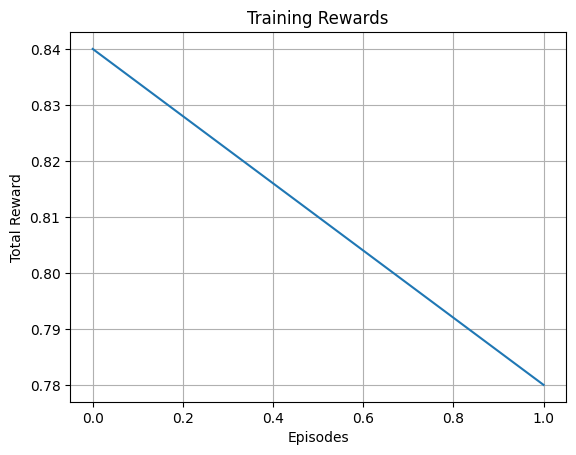

Episode 15/10000, Score: 0.9, Epsilon: 0.96


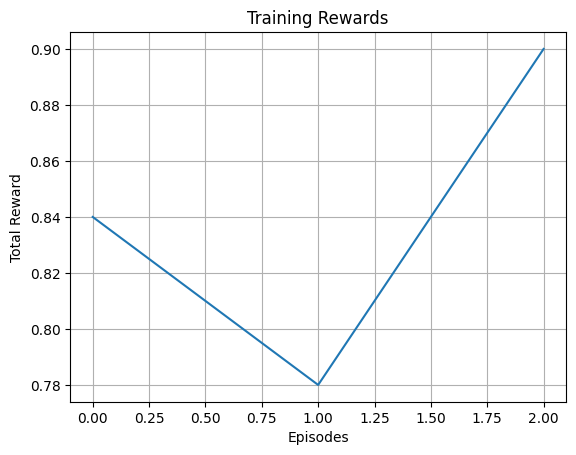

Episode 20/10000, Score: 1.2200000000000002, Epsilon: 0.95


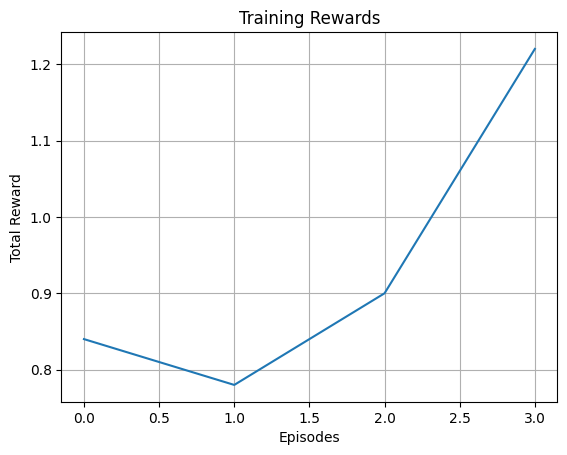

Episode 25/10000, Score: 0.9400000000000001, Epsilon: 0.93


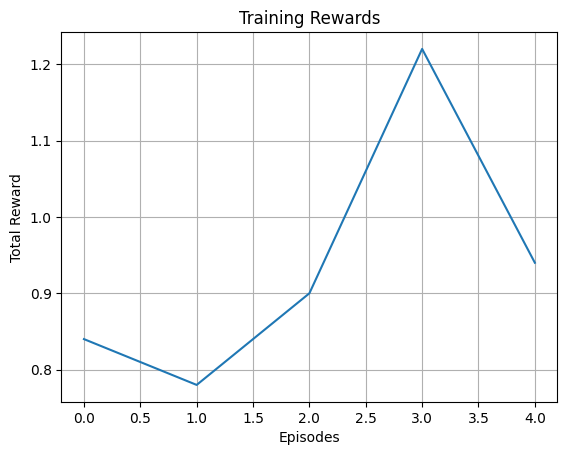

Episode 30/10000, Score: 0.9599999999999997, Epsilon: 0.92


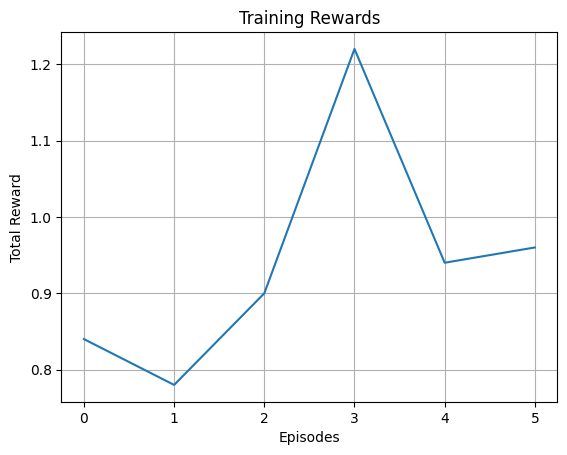

Episode 35/10000, Score: 0.9, Epsilon: 0.91


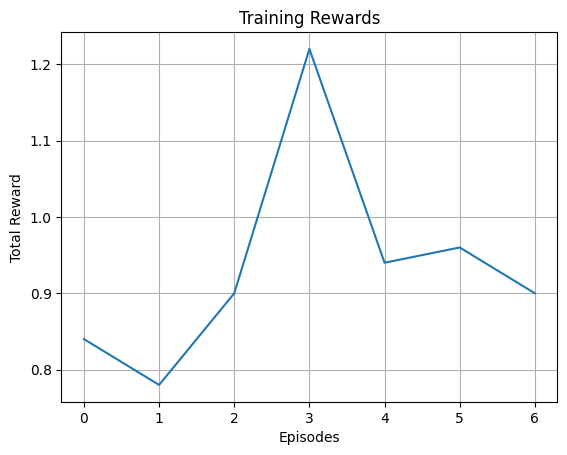

Episode 40/10000, Score: 0.82, Epsilon: 0.89


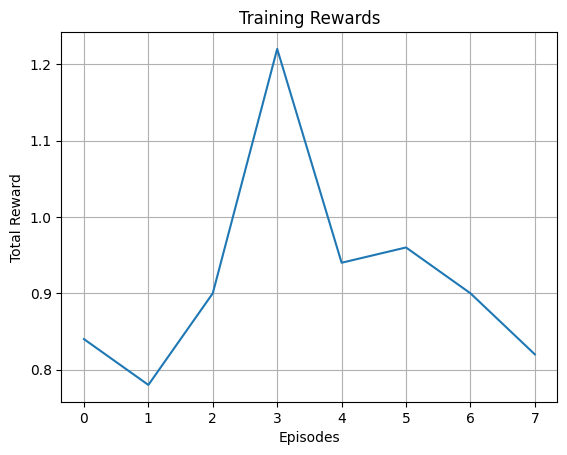

Episode 45/10000, Score: 1.1, Epsilon: 0.88


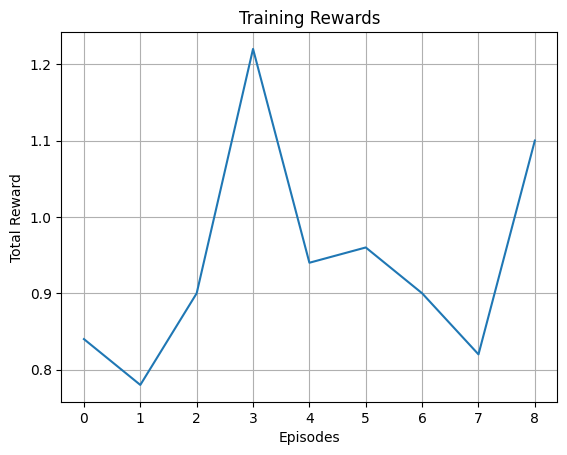

Episode 50/10000, Score: 1.0, Epsilon: 0.87


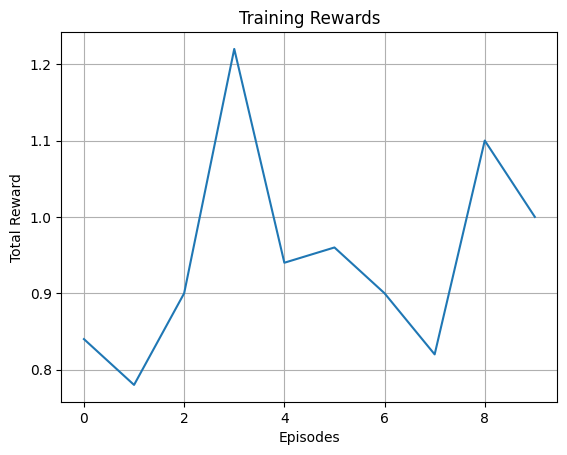

Episode 55/10000, Score: 0.9, Epsilon: 0.85


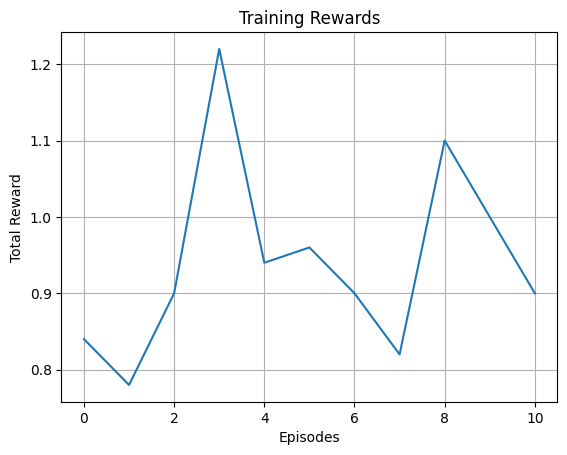

Episode 60/10000, Score: 1.1, Epsilon: 0.84


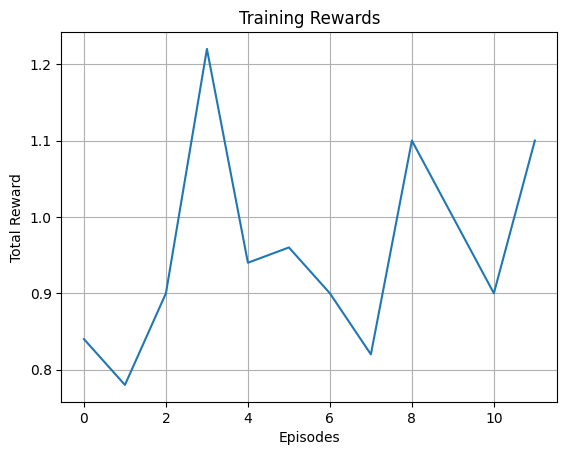

Episode 65/10000, Score: 0.72, Epsilon: 0.83


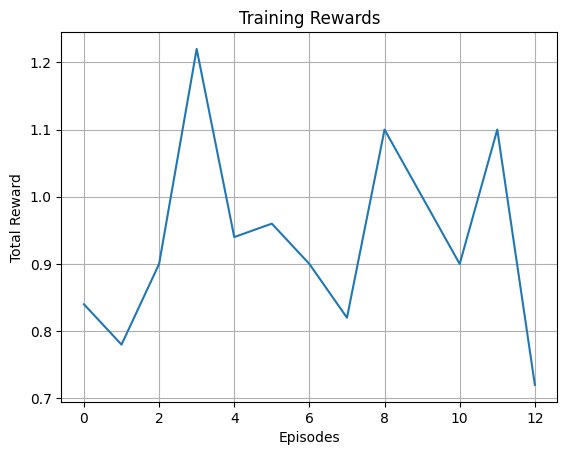

Episode 70/10000, Score: 0.8400000000000001, Epsilon: 0.82


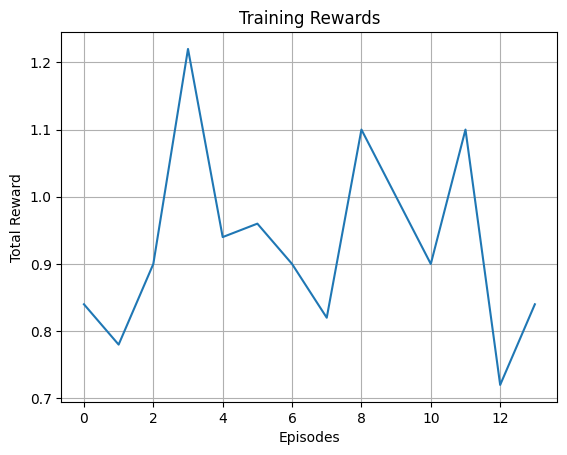

Episode 75/10000, Score: 1.22, Epsilon: 0.81


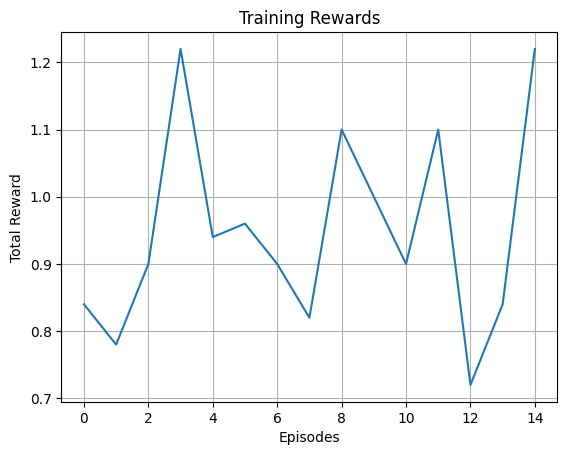

Episode 80/10000, Score: 0.8600000000000001, Epsilon: 0.79


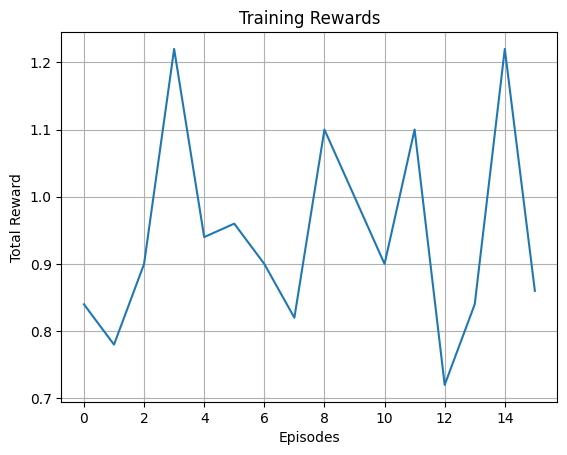

Episode 85/10000, Score: 1.1400000000000001, Epsilon: 0.78


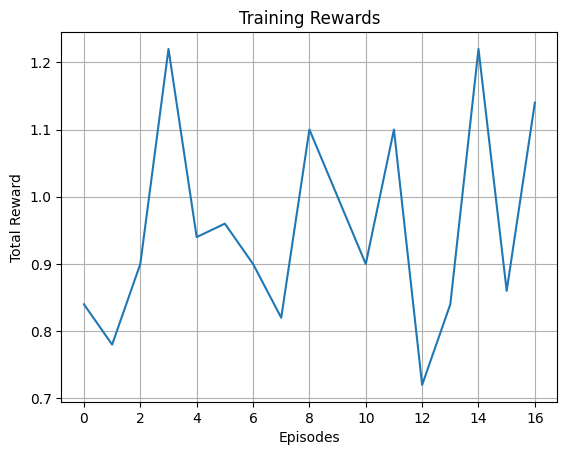

Episode 90/10000, Score: 0.74, Epsilon: 0.77


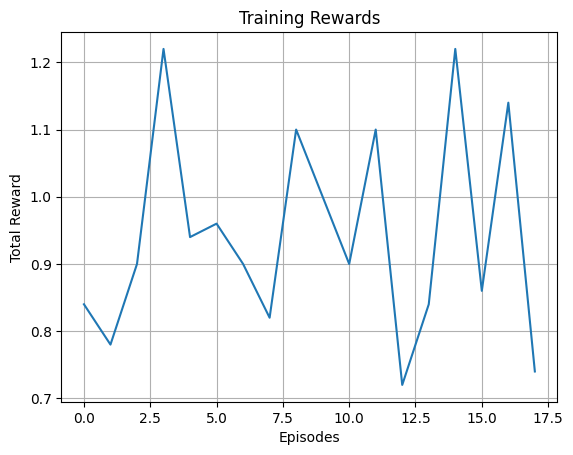

Episode 95/10000, Score: 0.96, Epsilon: 0.76


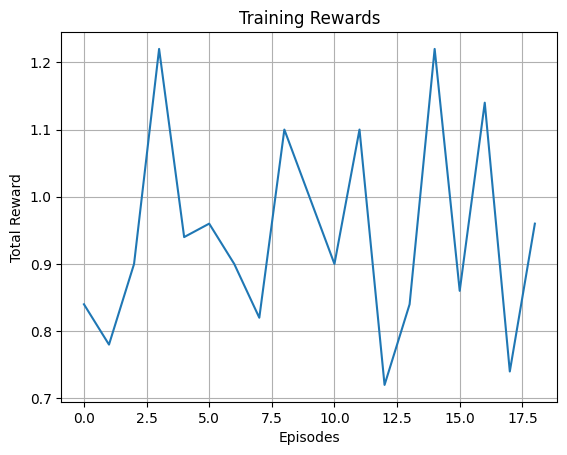

Episode 100/10000, Score: 0.74, Epsilon: 0.75


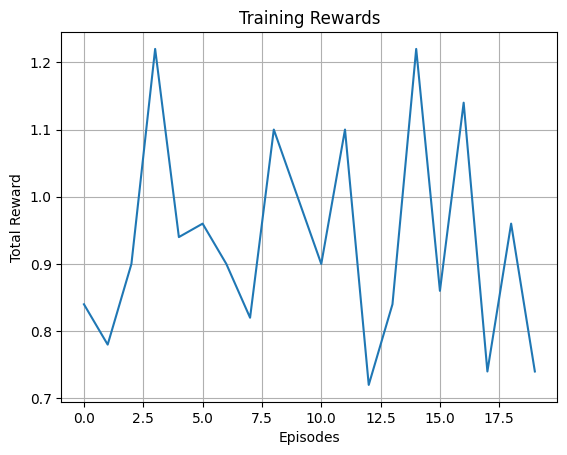

Episode 105/10000, Score: 0.7799999999999999, Epsilon: 0.74


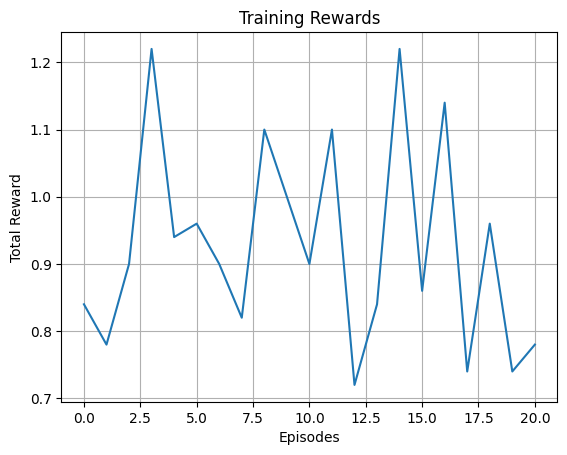

Episode 110/10000, Score: 1.04, Epsilon: 0.73


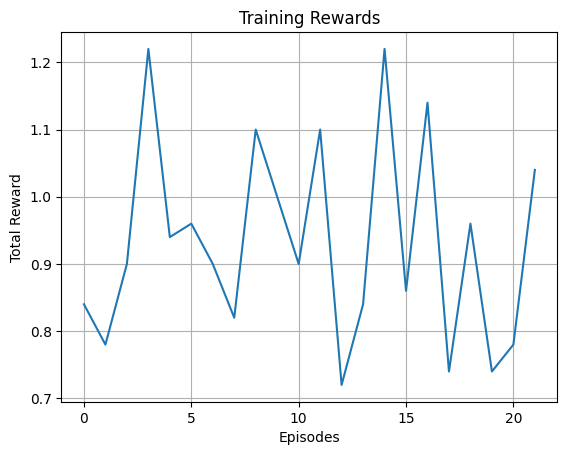

Episode 115/10000, Score: 0.8800000000000001, Epsilon: 0.72


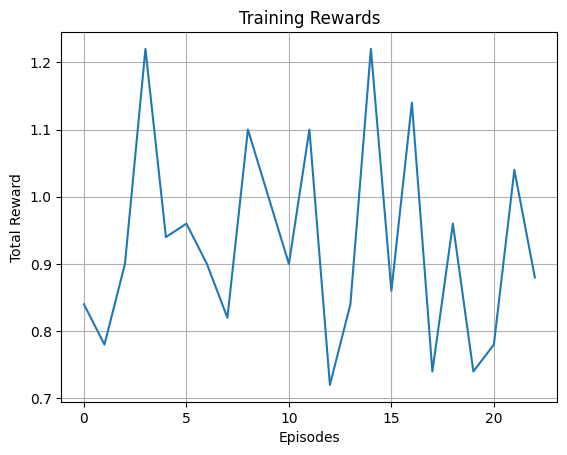

Episode 120/10000, Score: 0.8999999999999998, Epsilon: 0.71


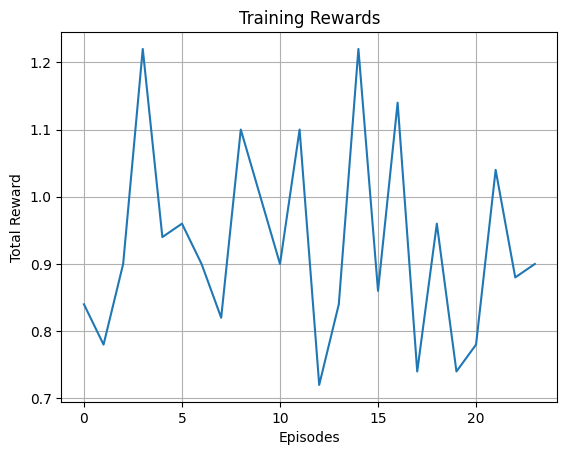

Episode 125/10000, Score: 0.6799999999999999, Epsilon: 0.70


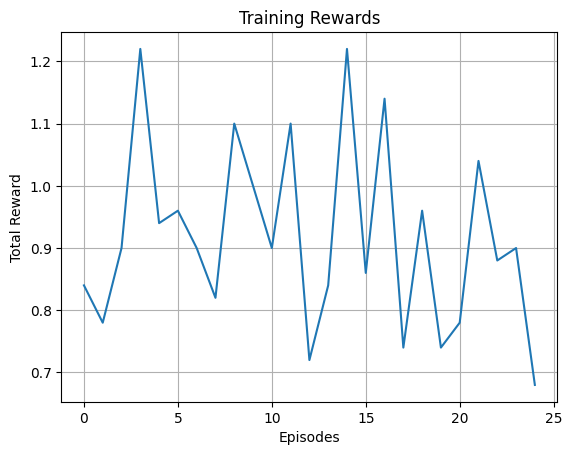

Episode 130/10000, Score: 0.72, Epsilon: 0.69


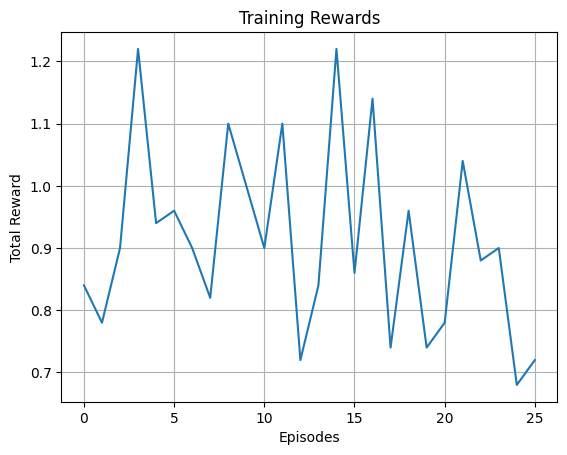

Episode 135/10000, Score: 0.64, Epsilon: 0.68


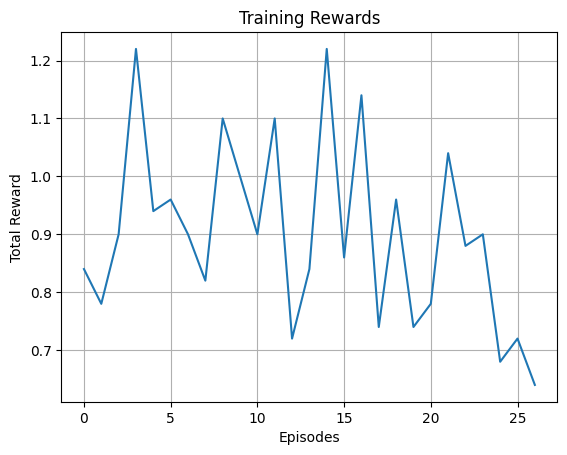

Episode 140/10000, Score: 0.72, Epsilon: 0.68


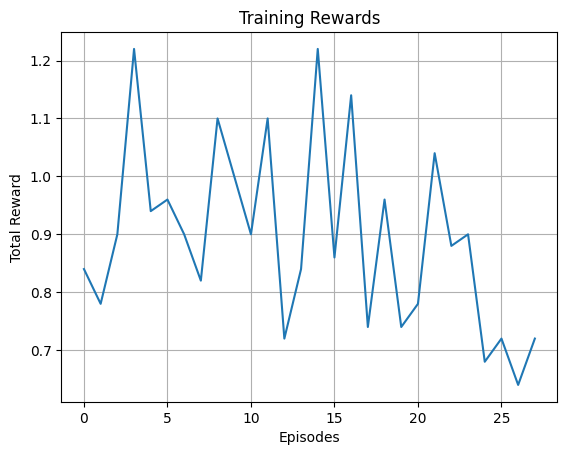

Episode 145/10000, Score: 0.9, Epsilon: 0.67


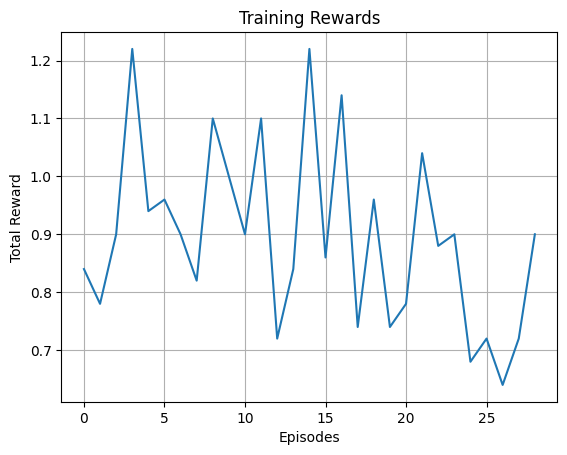

Episode 150/10000, Score: 0.9399999999999998, Epsilon: 0.66


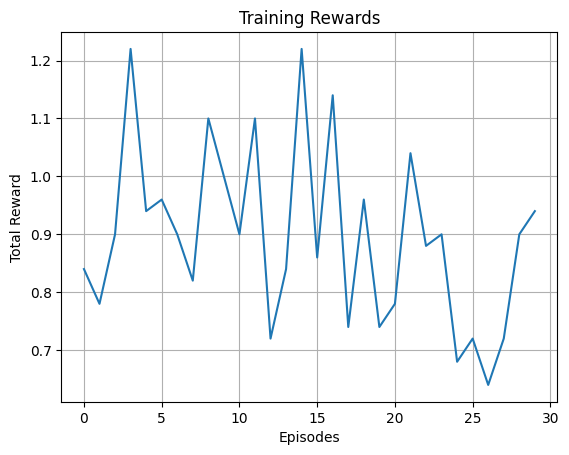

Episode 155/10000, Score: 1.12, Epsilon: 0.65


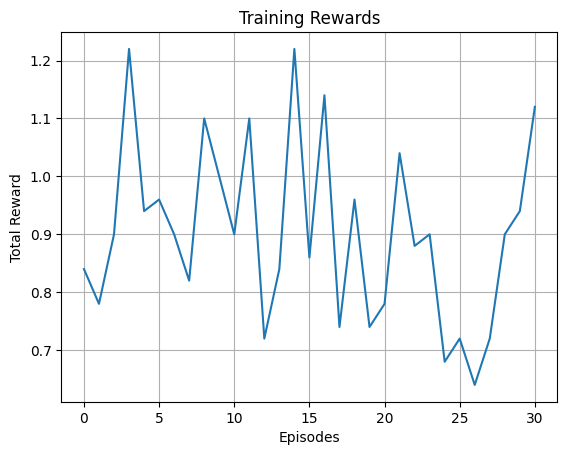

Episode 160/10000, Score: 0.4600000000000001, Epsilon: 0.64


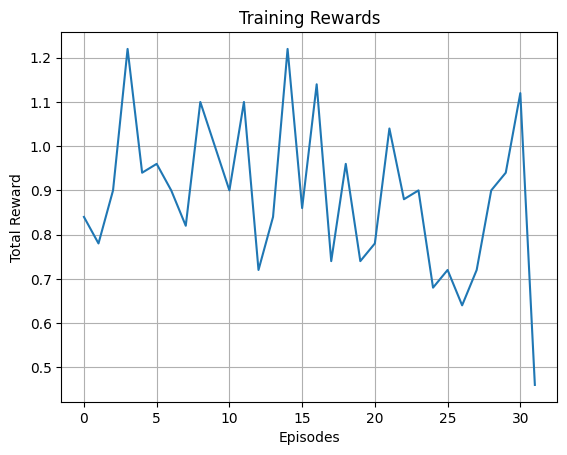

Episode 165/10000, Score: 0.9199999999999999, Epsilon: 0.63


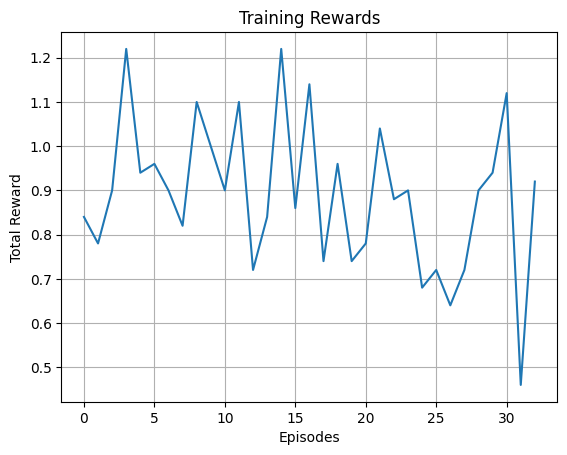

Episode 170/10000, Score: 0.7, Epsilon: 0.62


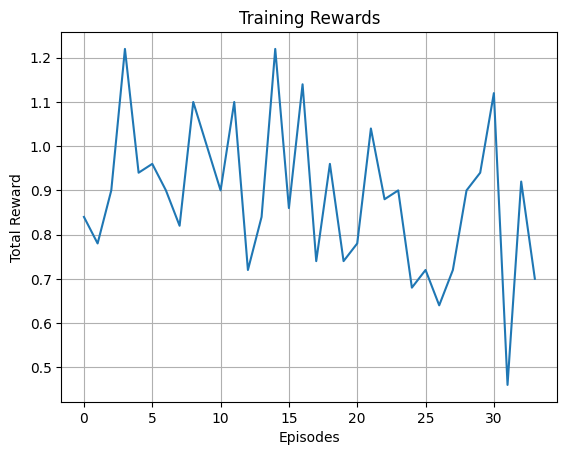

Episode 175/10000, Score: 0.76, Epsilon: 0.61


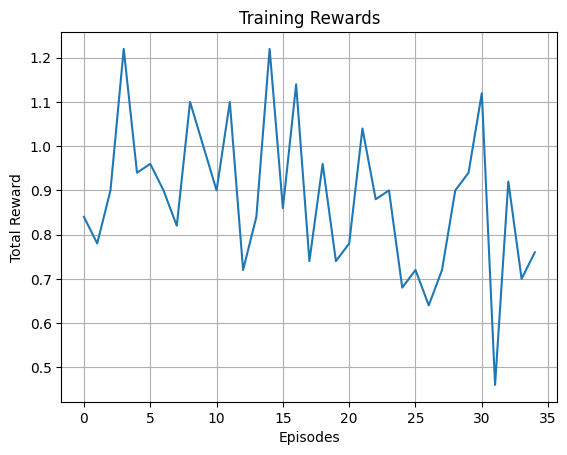

Episode 180/10000, Score: 0.8799999999999999, Epsilon: 0.60


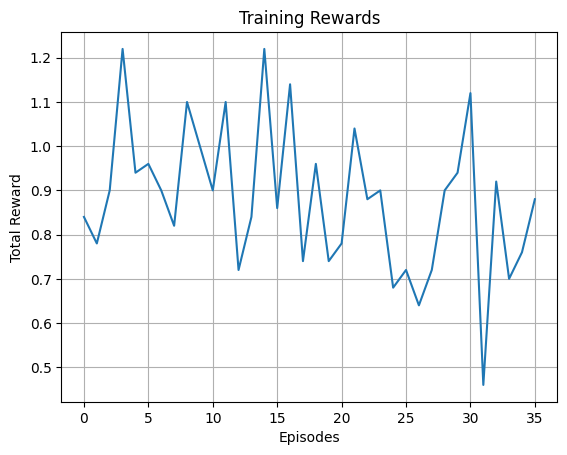

Episode 185/10000, Score: 0.5999999999999999, Epsilon: 0.60


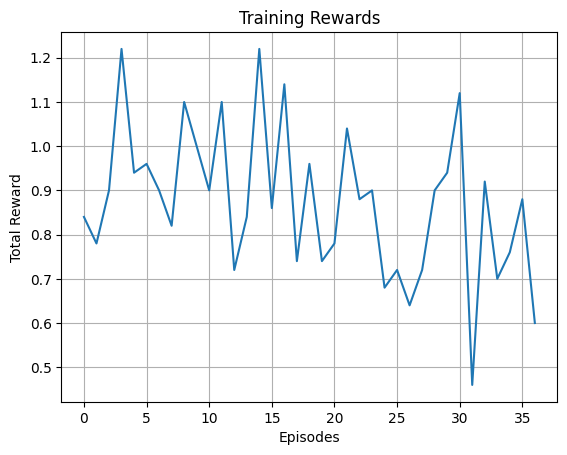

Episode 190/10000, Score: 0.74, Epsilon: 0.59


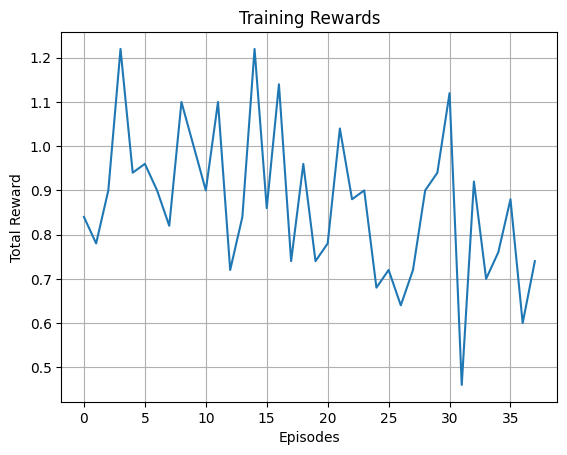

Episode 195/10000, Score: 0.64, Epsilon: 0.58


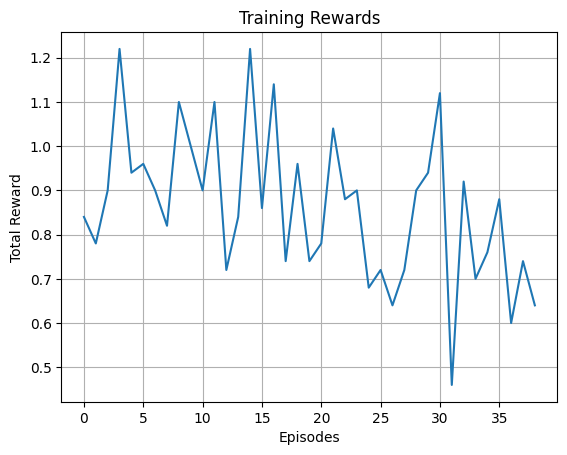

Episode 200/10000, Score: 0.64, Epsilon: 0.57


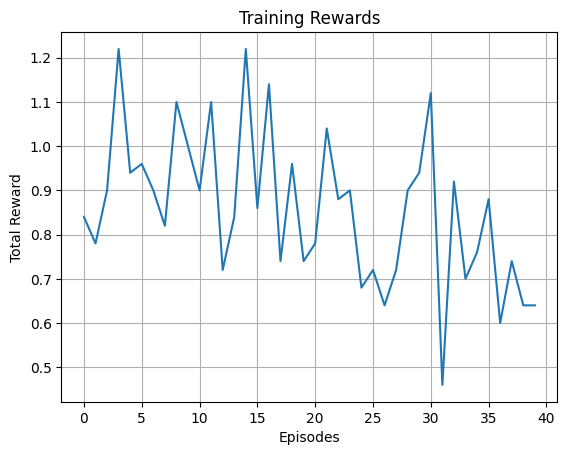

Episode 205/10000, Score: 1.06, Epsilon: 0.56


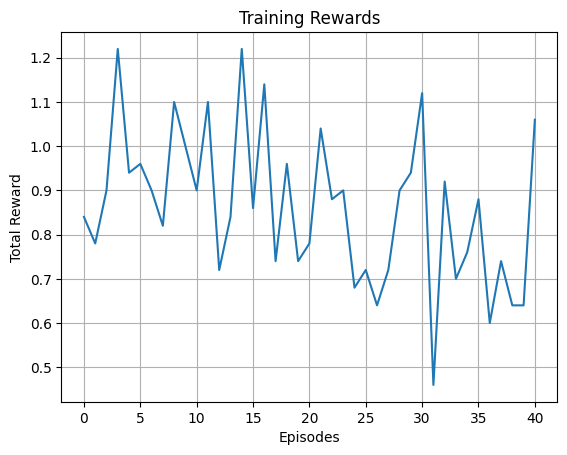

Episode 210/10000, Score: 0.82, Epsilon: 0.56


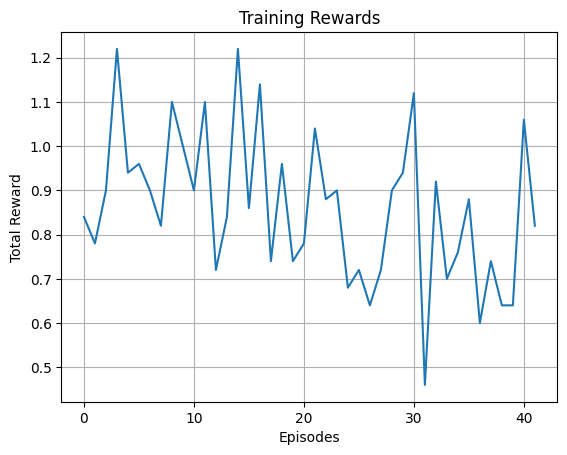

Episode 215/10000, Score: 0.38, Epsilon: 0.55


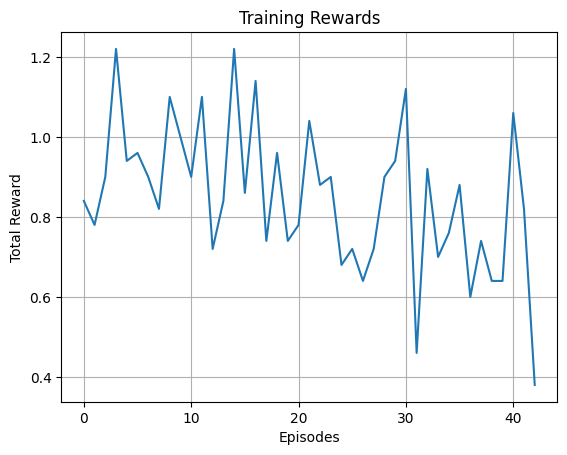

Episode 220/10000, Score: 0.42000000000000004, Epsilon: 0.54


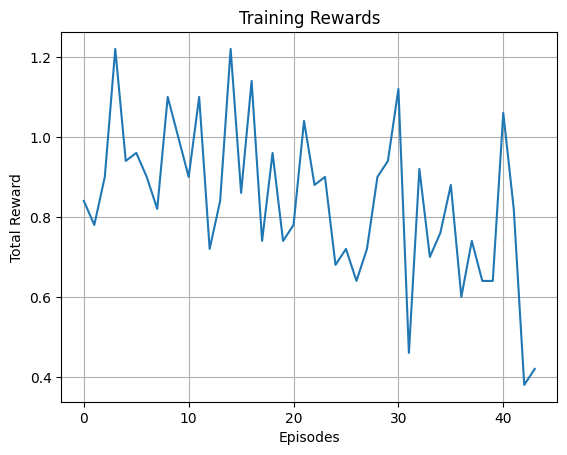

Episode 225/10000, Score: 0.6399999999999999, Epsilon: 0.54


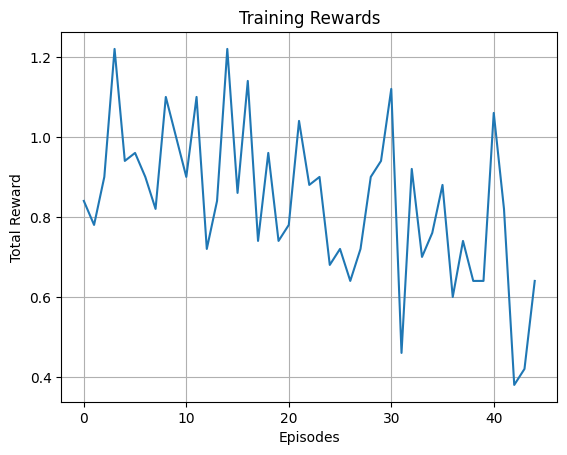

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f19677a0fa0>>
Traceback (most recent call last):
  File "/home/billyka/retro-env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [72]:
input_dim = (stacked_frames, 67, 72) 

output_dim = env.action_space.n 
agent = DQNAgent(env, input_dim, output_dim)
scores = agent.train()


state = env.reset()
done = False
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state

env.close()

# Problem Stellung

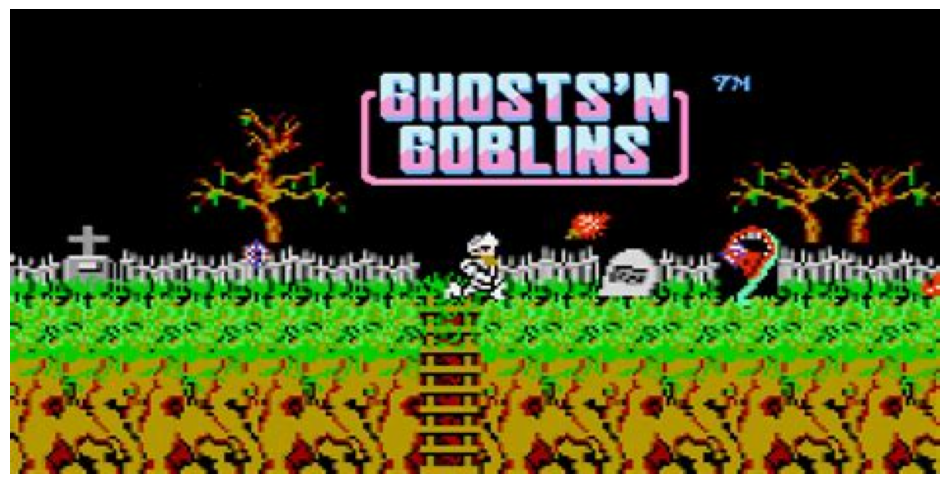

In [33]:
image_path = '/home/billyka/Documents/IKG_HTW/Big_Data_KI/GhostsnGoblins/dqn/th-2545763042.jpg'
image = mpimg.imread(image_path)
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off') 
plt.show()

# Daten

##  -State
##  -Action Space
##  -Reward
##  -Environment

# Deep Q Network


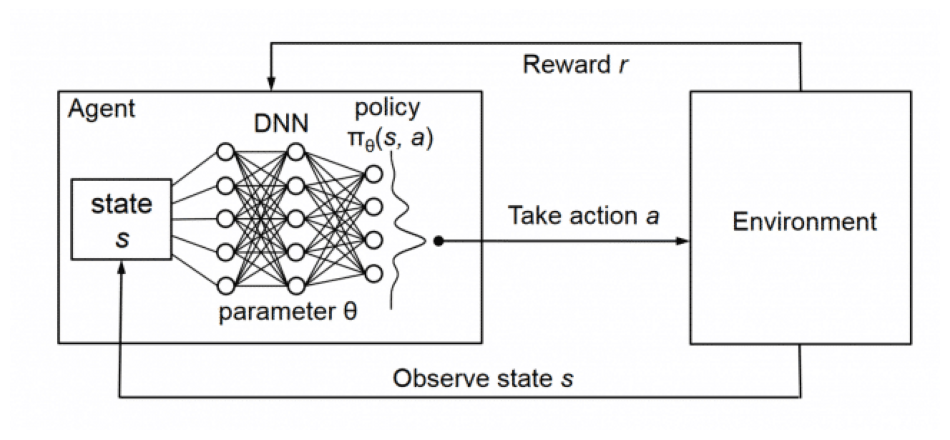

In [32]:
image_path = '/home/billyka/Documents/IKG_HTW/Datenschutz und Datensicherheit/dqn-architecture.png'
image = mpimg.imread(image_path)
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off') 
plt.show()

# State

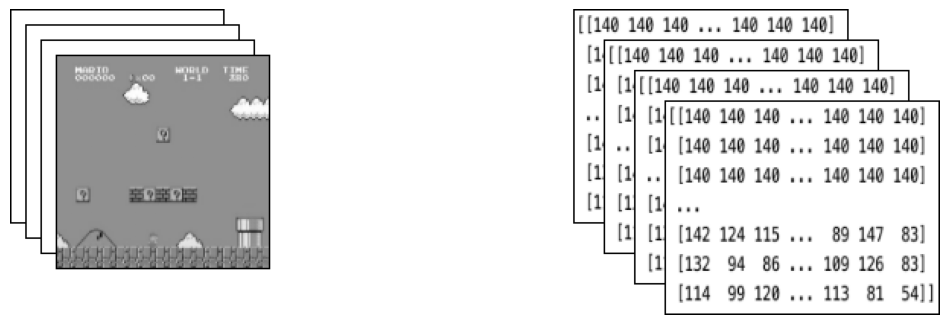

In [31]:
image_path = 'mario_env.png'
image = mpimg.imread(image_path)
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off') 
plt.show()

In [36]:
print(env.action_space.sample())
print(env.buttons)

[1 0 0 0 0 0 1 1 1]
['B', None, 'SELECT', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'A']


# Action Space

### [1 0 0 0 0 0 1 1 1]
### ['B', None, 'SELECT', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'A']




# reward



### if info["score"] % 200 == 0 and score != info["score"]:
###                    reward += 0.1
###                    score = info["score"]
###                total_seconds = info["time_minutes"] * 60 + info["time_tens"] * 10 + info["time_ones"]
###                if time > total_seconds:
###                    reward += 0.025
###                    time = total_seconds

# Environment

### next_state, reward, done, truncated, info = self.env.step(action)

# Ergebnis von Double Deep Q-Network zum Vergleich:

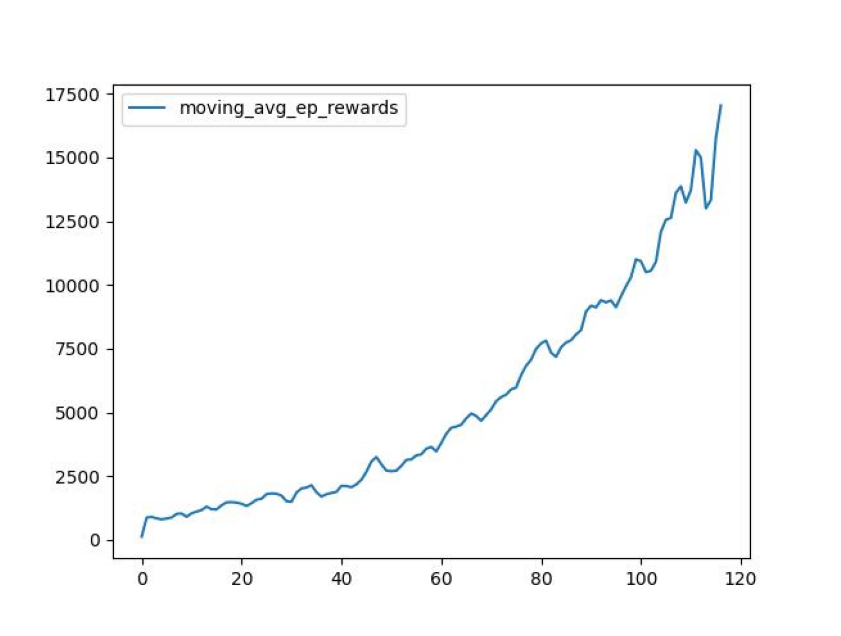

In [3]:
image_path = '/home/billyka/Documents/IKG_HTW/Big_Data_KI/GhostsnGoblins/checkpoints/2024-05-08T17-12-35/reward_plot.jpg'
image = mpimg.imread(image_path)
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off') 
plt.show()

# Quellen
#### https://miro.medium.com/v2/resize:fit:650/1*7YaeVSDiv9kg7B69GxbTWA.png
#### https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ffs-prod-cdn.nintendo-europe.com%2Fmedia%2Fimages%2F10_share_images%2Fgames_15%2Fnes_5%2FH2x1_NES_GhostNGoblins_image1600w.jpg&f=1&nofb=1&ipt=dd963dcc53f8f0ef052d16eba09173bd915595685d3a00d0443810ae7f313fc2&ipo=images
#### https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
#### https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html